In [1]:
import numpy as np
import re
import nltk
import json
from nltk.corpus import stopwords
import pymorphy2
import dgl
import networkx as nx
from networkx.readwrite import json_graph
import torch.nn as nn
import torch.nn.functional as F
import itertools
import torch
import matplotlib.pyplot as plt
import os
import re
import requests
from bs4 import BeautifulSoup
import time

## Создание графа dgl из графа networkx

In [628]:
with open('nodes_links_tensor_bert_dp.json', 'r') as f:
    g = json.load(f)

In [636]:
for node in g['nodes']:
    node['id'] = node['id'] - 1

for link in g['links']:
    link['source'] = link['source'] - 1
    link['target'] = link['target'] - 1

In [644]:
G = nx.DiGraph(nx.node_link_graph(g))

In [383]:
graph_dgl = dgl.from_networkx(G, node_attrs=['address'], edge_attrs =['weight'])

## Positive and negative sampling

In [384]:
import scipy.sparse as sp
import random
import itertools
u, v = graph_dgl.edges()

eids = np.arange(graph_dgl.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
val_size = int(len(eids) * 0.1)
train_size = graph_dgl.number_of_edges() - test_size - val_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
val_pos_u, val_pos_v = u[eids[test_size:test_size+val_size]], v[eids[test_size:test_size+val_size]]
train_pos_u, train_pos_v = u[eids[test_size+val_size:]], v[eids[test_size+val_size:]]

#Все возможные комбинации узлов source с target (u с v)
nall_comb = list(itertools.product(torch.unique(u).cpu().numpy(),torch.unique(v).cpu().numpy()))
ed = list(G.edges)

#Negative example
neg = list(set(nall_comb) - set(ed))
neg_u = []
neg_v = []

for e in neg:
    neg_u.append(e[0])
    neg_v.append(e[1])

neg_u, neg_v = np.array(neg_u), np.array(neg_v) 
neg_eids = np.random.choice(len(neg_u), graph_dgl.number_of_edges())


test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size+val_size]], neg_v[neg_eids[test_size:test_size+val_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size+val_size:]], neg_v[neg_eids[test_size+val_size:]]

In [385]:
train_g = dgl.remove_edges(graph_dgl, eids[:test_size+val_size]) #тренировочный датасет

In [386]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=graph_dgl.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=graph_dgl.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=graph_dgl.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=graph_dgl.number_of_nodes())

val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=graph_dgl.number_of_nodes())
val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=graph_dgl.number_of_nodes())

## Создание атрибутов на ребрах

In [387]:
def pos_attr(g, pos_u, pos_v):
    for l in range(len(pos_u)):
        i, j = pos_u[l], pos_v[l]
        g.edges[i, j].data['weight'] = graph_dgl.edges[i, j].data['weight']
        
    return g
def neg_attr(g, neg_u, neg_v, G=G):
    for l in range(len(neg_u)):
        i, j_fict = neg_u[l], neg_v[l]
        j = random.choice([n-1 for n in G.neighbors(i+1)])
        
        g.edges[i, j_fict].data['weight'] = graph_dgl.edges[i, j].data['weight']
    return g

In [388]:
train_pos_g = pos_attr(train_pos_g, train_pos_u, train_pos_v)
test_pos_g = pos_attr(test_pos_g, test_pos_u, test_pos_v)
val_pos_g = pos_attr(val_pos_g, val_pos_u, val_pos_v)
train_neg_g = neg_attr(train_neg_g, train_neg_u, train_neg_v)
test_neg_g = neg_attr(test_neg_g, test_neg_u, test_neg_v)
val_neg_g = neg_attr(val_neg_g, val_neg_u, val_neg_v)

## Message Passing

In [1068]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats*2+768+3,h_feats) # 
        self.W2 = nn.Linear(h_feats, 1)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h'],edges.data['weight']], 1)
        return {'score': self.sigmoid(self.W2(self.leaky_relu(self.W1(F.normalize(h))))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']



# Модель GraphSAGE

## GraphSAGE layer
\begin{align}\begin{aligned}
\\h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}
\left(\{e_{ji} h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)
\\h_{i}^{(l+1)} &= \sigma \left(W \cdot \mathrm{concat}
(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)\\h_{i}^{(l+1)} &= \mathrm{norm}(h_{i}^{(l+1)})\end{aligned}\end{align}

**Aggregator: pool, mean, lstm**

In [879]:
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, agg):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats,agg)
        self.conv2 = SAGEConv(h_feats, h_feats, agg)
# 768+3 = вектор после берт-преобразования (768) + 3 доп признаки: ФЗ (ohe размерности 2) и стоимость (1 элемент)
        self.linear1 = nn.Linear(768+3, 256) 
        self.linear2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
    def forward(self, g, in_feat, edge_weight):
        
        edge_weight =self.linear2((self.linear1(edge_weight)))
        
        h = self.conv1(g, in_feat, edge_weight) #учитывается атрибут ребра
        h = F.relu(h)
        h = self.conv2(g, h) 
        return h

## Функция потерь binary_cross_entropy: 
\begin{align}\begin{aligned}ℓ(x,y)=L=\{l_1,…,l_N\}^⊤
\\l_n=−w_n[y_n\cdot logx_n+(1−y_n)\cdot log(1−x_n)]
\end{aligned}\end{align}
 

In [880]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).detach().numpy()
    return roc_auc_score(labels, scores)

def compute_acc(pos_score, neg_score):
    scores = torch.cat([pos_score.round(), neg_score.round()]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return accuracy_score(labels, scores)

def compute_f1(pos_score, neg_score):
    scores = torch.cat([pos_score.round(), neg_score.round()]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).detach().numpy()
    return f1_score(labels, scores)

def conf_matrix(pos_score, neg_score):
    scores = torch.cat([pos_score.round(), neg_score.round()]).detach().numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).detach().numpy()
    return confusion_matrix(scores, labels)

## Метрики: 
\begin{align}\begin{aligned}
\cdot accuracy = \frac {TP + TN} {TP + TN + FP + FN}
\\
\\\cdot f1 =   \frac {2} {recall^{-1} + precision^{-1}} = 2\cdot \frac {precision \cdot recall} {precision + recall}
\end{aligned}\end{align}

In [881]:
def train(train_g, model, pred, optimizer, compute_loss):
    #model.train()
    
    h = model(train_g, train_g.ndata['address'],train_g.edata['weight'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    acc = compute_acc(pos_score, neg_score)
    f1 = compute_f1(pos_score, neg_score)
    auc = compute_auc(pos_score, neg_score)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, h, acc, f1, auc

def val(val_pos_g, val_neg_g, model, h, pred, compute_loss, compute_acc, compute_f1):
    #model.eval()
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
    return compute_loss(pos_score, neg_score), compute_acc(pos_score, neg_score), compute_f1(pos_score, neg_score)

def test(test_pos_g,test_neg_g, h, model, pred, compute_loss, compute_acc, compute_f1, compute_auc):
    model.eval()
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
    return compute_loss(pos_score, neg_score), compute_acc(pos_score, neg_score), compute_f1(pos_score, neg_score), compute_auc(pos_score, neg_score), conf_matrix(pos_score, neg_score)


# Mean aggregator

In [1139]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

n = train_g.ndata['address'].shape[1]
# параметры GraphSAGE: размерность исходных атрибутов, размерность после свертки, функция агрегации 
model_mean = GraphSAGE(n, 128 ,'mean')
pred_mean = MLPPredictor(128)
optimizer = torch.optim.Adam(itertools.chain(model_mean.parameters(), pred_mean.parameters()), lr=0.01)

## Train and validation

In [1140]:
%%time
acc_val, acc_train, lossess_train, lossess = [], [], [], []
f1_val, f1_train = [], []
epoch = 85
model_mean.train()
for e in range(epoch):
    
    loss, h_mean, acc, f1, auc= train(train_g, model_mean, pred_mean, optimizer, compute_loss)
    val_loss, val_acc, val_f1 =val(val_pos_g, val_neg_g, model_mean, h_mean, pred_mean, compute_loss, compute_acc, compute_f1)
    acc_val.append(val_acc)
    acc_train.append(acc)
    lossess_train.append(loss.detach().numpy())
    f1_val.append(val_f1)
    f1_train.append(f1)
    lossess.append(val_loss)
    
    #if e%5 == 0:  
    print('In epoch {}, loss: {}'.format(e, loss))
    print(f'val_loss: {val_loss}, val_acc: {val_acc}, val_f1: {val_f1}')
    print('------------------------------------------------------------')

In epoch 0, loss: 0.6932189464569092
val_loss: 0.6849340200424194, val_acc: 0.5374190938511327, val_f1: 0.4428745432399513
------------------------------------------------------------
In epoch 1, loss: 0.6930872797966003
val_loss: 0.6909316182136536, val_acc: 0.5038430420711975, val_f1: 0.6677502370310172
------------------------------------------------------------
In epoch 2, loss: 0.6944994926452637
val_loss: 0.6911075711250305, val_acc: 0.5, val_f1: 0.6666666666666666
------------------------------------------------------------
In epoch 3, loss: 0.6892380118370056
val_loss: 0.6881819367408752, val_acc: 0.5343851132686084, val_f1: 0.4573314474304573
------------------------------------------------------------
In epoch 4, loss: 0.6876042485237122
val_loss: 0.6858265399932861, val_acc: 0.5408576051779935, val_f1: 0.44308145240431795
------------------------------------------------------------
In epoch 5, loss: 0.6845520734786987
val_loss: 0.6815807223320007, val_acc: 0.5396440129449838

In epoch 45, loss: 0.5343545079231262
val_loss: 0.5398361086845398, val_acc: 0.7437297734627831, val_f1: 0.7505414451663713
------------------------------------------------------------
In epoch 46, loss: 0.5374688506126404
val_loss: 0.543082594871521, val_acc: 0.7382686084142395, val_f1: 0.7454760031471283
------------------------------------------------------------
In epoch 47, loss: 0.5331282019615173
val_loss: 0.5378872752189636, val_acc: 0.7479773462783171, val_f1: 0.7486889874949577
------------------------------------------------------------
In epoch 48, loss: 0.5341004729270935
val_loss: 0.5372805595397949, val_acc: 0.7449433656957929, val_f1: 0.7491545653471254
------------------------------------------------------------
In epoch 49, loss: 0.531113862991333
val_loss: 0.537344753742218, val_acc: 0.74292071197411, val_f1: 0.7547752267026819
------------------------------------------------------------
In epoch 50, loss: 0.5310797095298767
val_loss: 0.536791980266571, val_acc: 0.74

## Test

In [1142]:
loss, acc, f1, auc, conf = test(test_pos_g, test_neg_g, h_mean, model_mean, pred_mean, compute_loss, compute_acc, compute_f1, compute_auc)

In [1143]:
print(f'loss = {loss}, accuracy = {acc}, F1 = {f1},AUC = {auc}')

loss = 0.516925036907196, accuracy = 0.7550566343042071, F1 = 0.7562889917488428,AUC = 0.8239635863417853


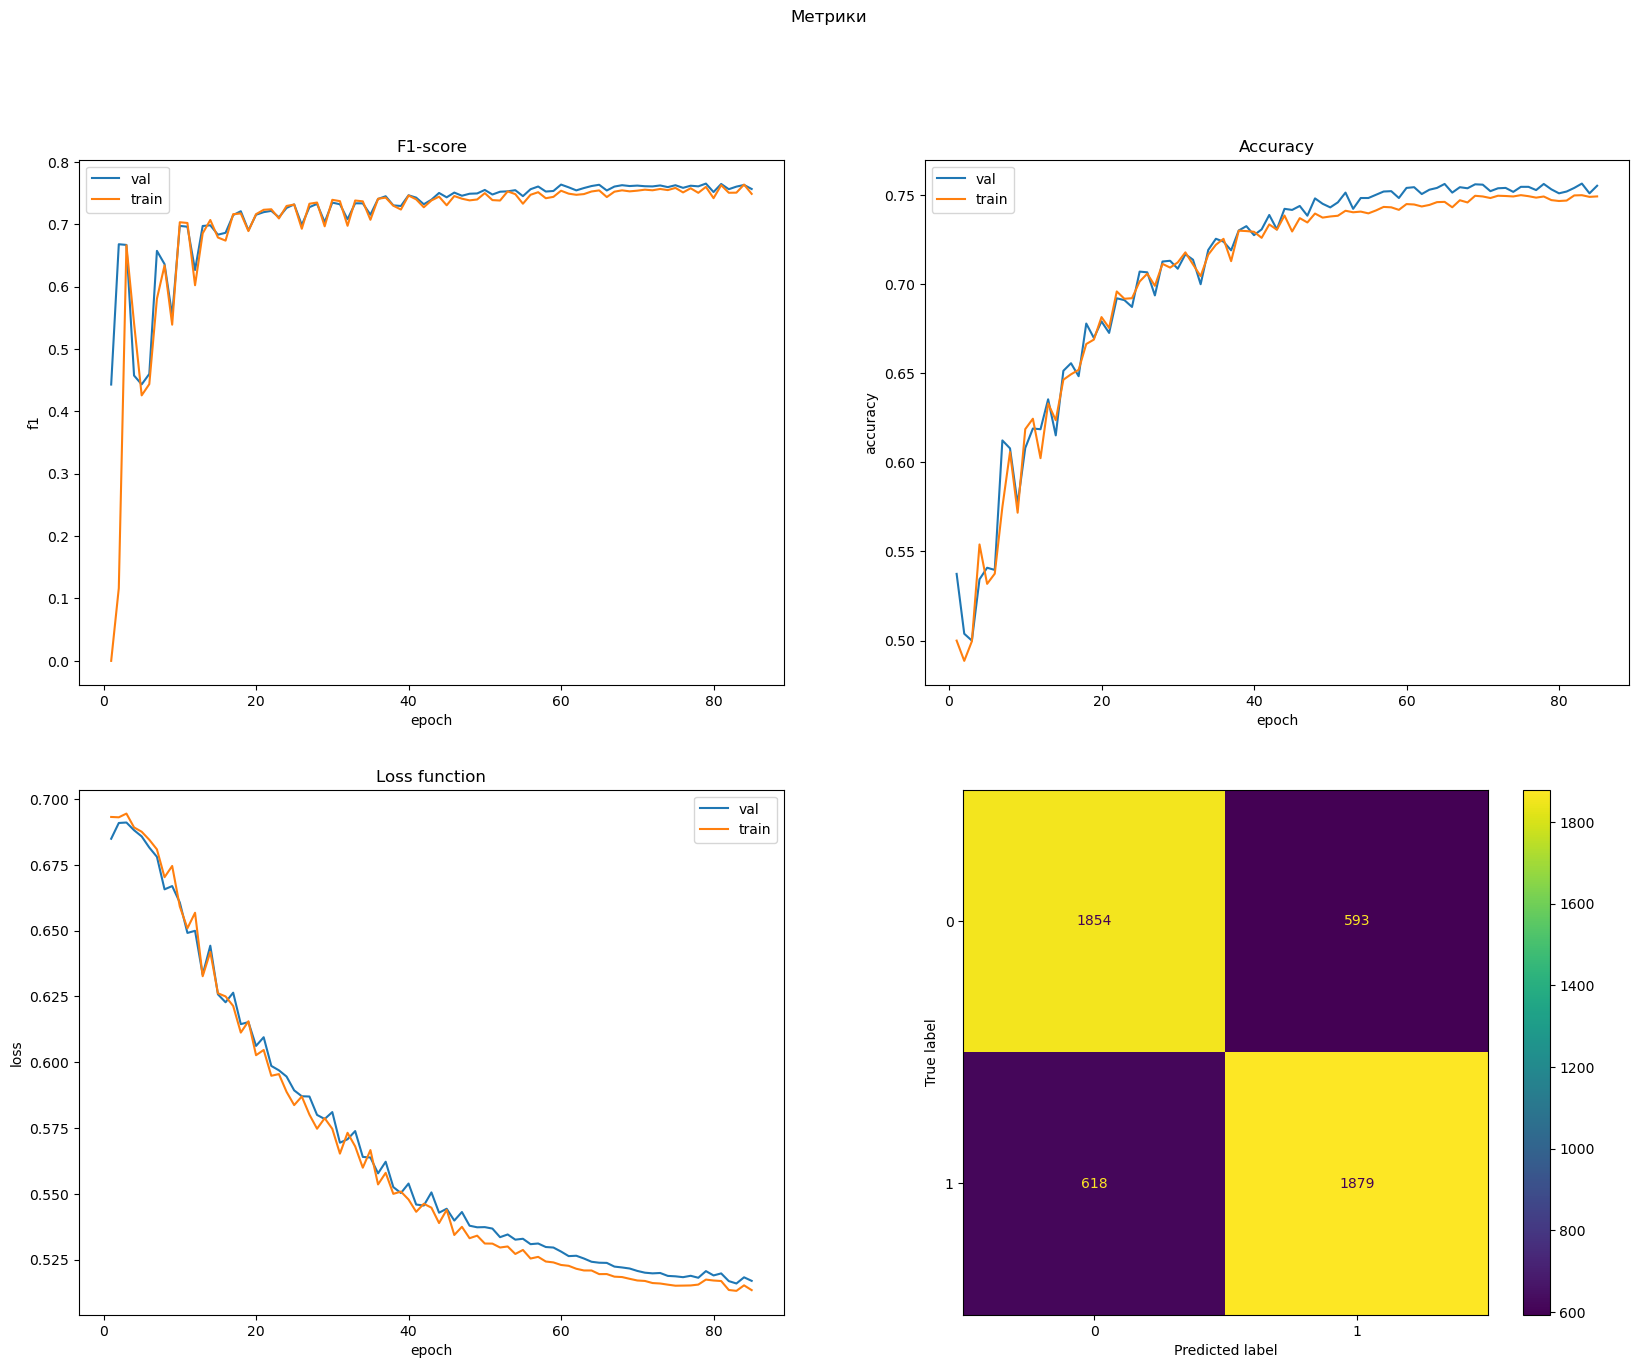

In [1144]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(2,2,figsize=(20, 15))
fig.suptitle('Метрики')
ax[0,0].plot(np.arange(1,epoch+1),f1_val, label = 'val')
ax[0,0].plot(np.arange(1,epoch+1),f1_train, label = 'train')
ax[0,0].legend()
ax[0,0].set_xlabel('epoch')
ax[0,0].set_ylabel('f1')
ax[0,0].set_title('F1-score')

ax[0,1].plot(np.arange(1,epoch+1),acc_val, label = 'val')
ax[0,1].plot(np.arange(1,epoch+1),acc_train, label = 'train')
ax[0,1].legend()
ax[0,1].set_xlabel('epoch')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_title('Accuracy')

ax[1,0].plot(np.arange(1,epoch+1),lossess, label = 'val')
ax[1,0].plot(np.arange(1,epoch+1),lossess_train, label = 'train')
ax[1,0].legend()
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title('Loss function')

ConfusionMatrixDisplay(conf).plot(ax = ax[1,1])

# Pool aggregator

In [1152]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

n = train_g.ndata['address'].shape[1]
# параметры GraphSAGE: размерность исходных атрибутов, размерность после свертки, функция агрегации 
model_pool = GraphSAGE(n, 128 ,'pool')
pred_pool = MLPPredictor(128)
optimizer = torch.optim.Adam(itertools.chain(model_pool.parameters(), pred_pool.parameters()), lr=0.01)

## Train and validation


In [1153]:
%%time
acc_val, acc_train, lossess_train, lossess = [], [], [], []
f1_val, f1_train = [], []
epoch = 50
train_g_loop = dgl.add_self_loop(train_g)
model_pool.train()
for e in range(epoch):
    
    loss, h_pool, acc, f1, auc= train(train_g, model_pool, pred_pool, optimizer, compute_loss)
    val_loss, val_acc, val_f1 =val(val_pos_g, val_neg_g, model_pool, h_pool, pred_pool, compute_loss, compute_acc, compute_f1)
    acc_val.append(val_acc)
    acc_train.append(acc)
    lossess_train.append(loss.detach().numpy())
    f1_val.append(val_f1)
    f1_train.append(f1)
    lossess.append(val_loss)
    
    #if e%5 == 0:  
    print('In epoch {}, loss: {}'.format(e, loss))
    print(f'val_loss: {val_loss}, val_acc: {val_acc}, val_f1: {val_f1}')
    print('------------------------------------------------------------')

In epoch 0, loss: 0.6931313872337341
val_loss: 0.6924093961715698, val_acc: 0.5103155339805825, val_f1: 0.6708361658735553
------------------------------------------------------------
In epoch 1, loss: 0.6814799904823303
val_loss: 0.6638502478599548, val_acc: 0.625, val_f1: 0.6849082256968049
------------------------------------------------------------
In epoch 2, loss: 0.6587777733802795
val_loss: 0.6486026048660278, val_acc: 0.6193365695792881, val_f1: 0.6578181818181817
------------------------------------------------------------
In epoch 3, loss: 0.6489524841308594
val_loss: 0.6567972898483276, val_acc: 0.6193365695792881, val_f1: 0.6535346097201767
------------------------------------------------------------
In epoch 4, loss: 0.6439990997314453
val_loss: 0.6485156416893005, val_acc: 0.625, val_f1: 0.6613080014614542
------------------------------------------------------------
In epoch 5, loss: 0.6246674060821533
val_loss: 0.6254114508628845, val_acc: 0.639967637540453, val_f1: 0.6

In epoch 45, loss: 0.5425692200660706
val_loss: 0.5472561717033386, val_acc: 0.735032362459547, val_f1: 0.7469088098918083
------------------------------------------------------------
In epoch 46, loss: 0.5361088514328003
val_loss: 0.5460108518600464, val_acc: 0.7368527508090615, val_f1: 0.7629805064674804
------------------------------------------------------------
In epoch 47, loss: 0.5369705557823181
val_loss: 0.5436245799064636, val_acc: 0.7326051779935275, val_f1: 0.7557280118255729
------------------------------------------------------------
In epoch 48, loss: 0.5398916602134705
val_loss: 0.544185221195221, val_acc: 0.727953074433657, val_f1: 0.738174031535916
------------------------------------------------------------
In epoch 49, loss: 0.5346978306770325
val_loss: 0.5432190895080566, val_acc: 0.7336165048543689, val_f1: 0.7528617001313568
------------------------------------------------------------
CPU times: user 52.5 s, sys: 26.2 s, total: 1min 18s
Wall time: 25.7 s


## Test

In [1154]:
loss, acc, f1, auc, conf = test(test_pos_g, test_neg_g, h_pool, model_pool, pred_pool, compute_loss, compute_acc, compute_f1, compute_auc)
print(f'loss = {loss}, accuracy = {acc}, F1 = {f1},AUC = {auc}')

loss = 0.5432190895080566, accuracy = 0.7336165048543689, F1 = 0.7528617001313568,AUC = 0.799961101554236


## Метрики 

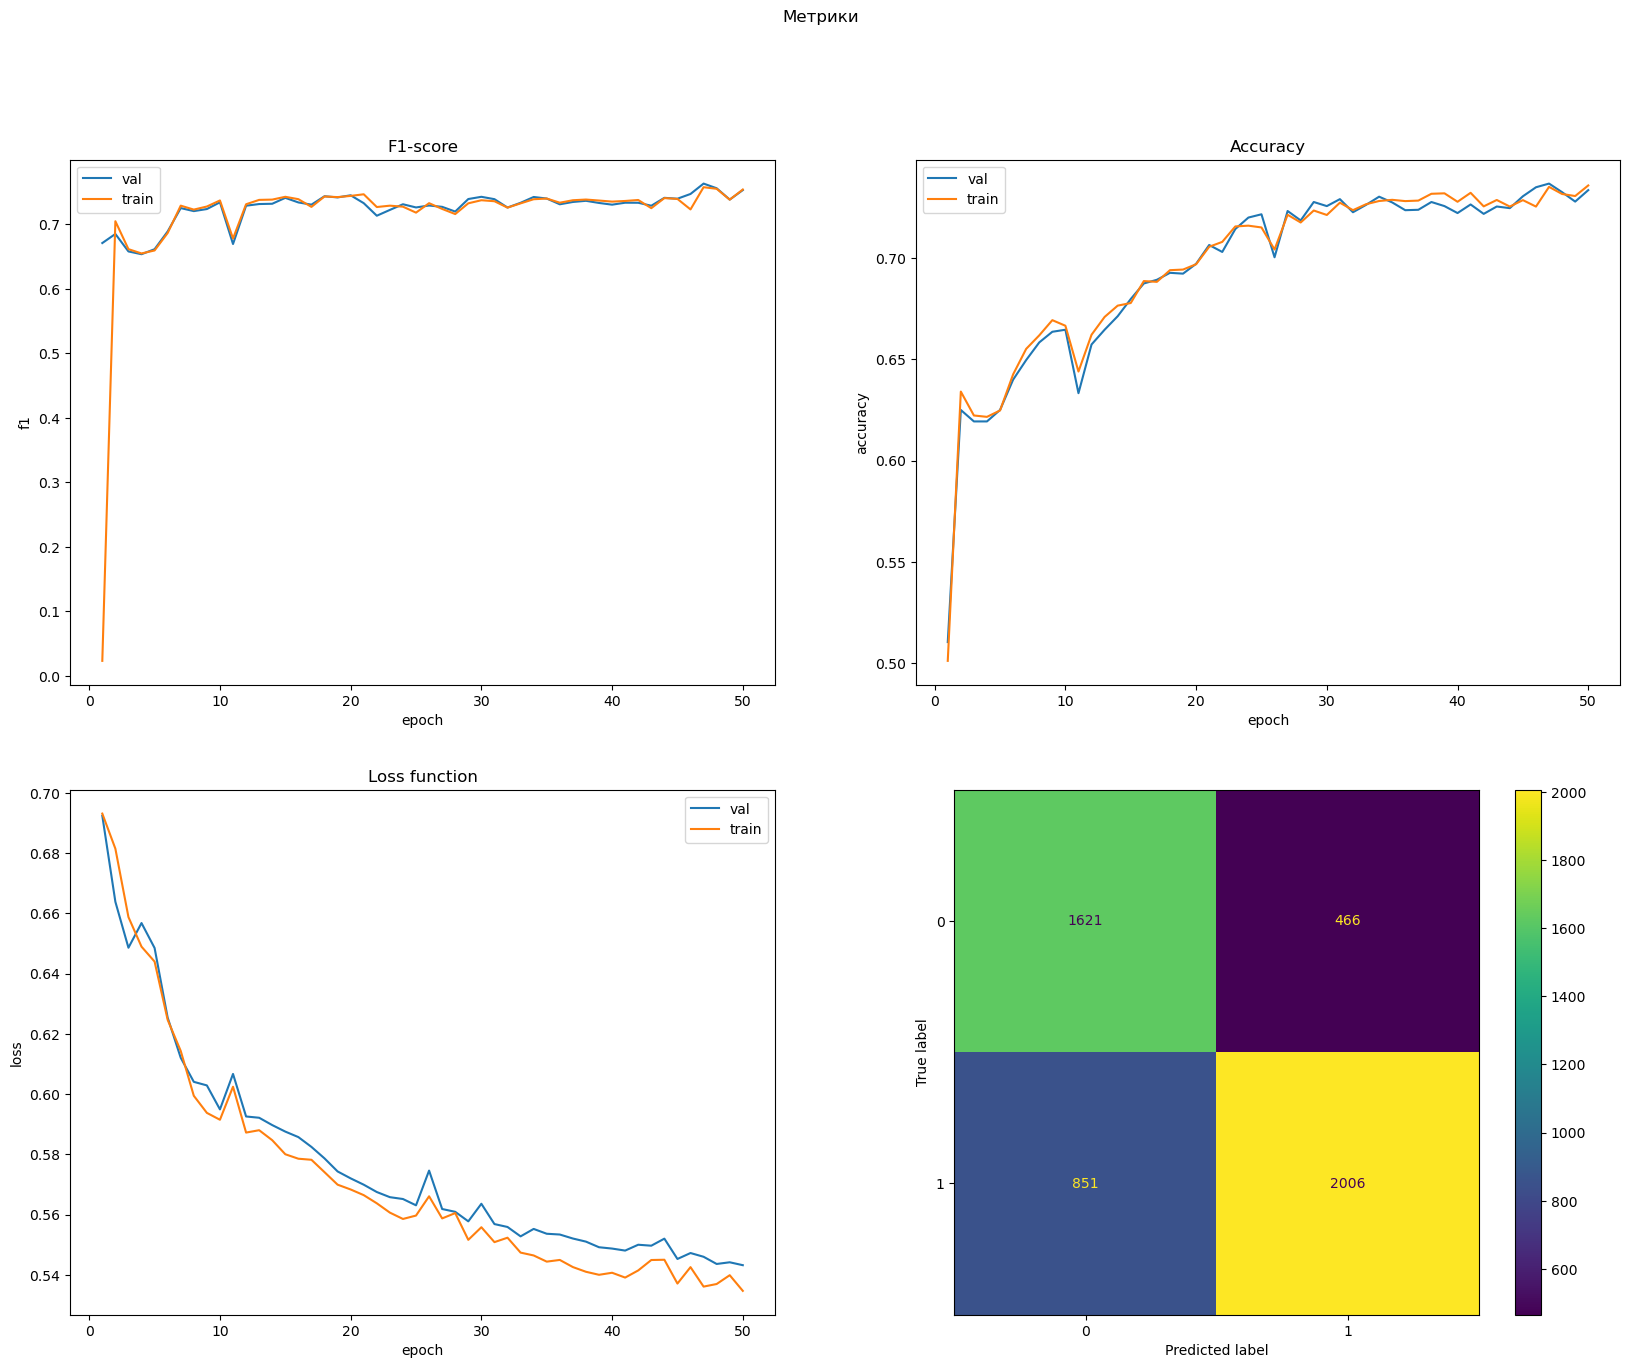

In [1155]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(2,2,figsize=(20, 15))
fig.suptitle('Метрики')
ax[0,0].plot(np.arange(1,epoch+1),f1_val, label = 'val')
ax[0,0].plot(np.arange(1,epoch+1),f1_train, label = 'train')
ax[0,0].legend()
ax[0,0].set_xlabel('epoch')
ax[0,0].set_ylabel('f1')
ax[0,0].set_title('F1-score')

ax[0,1].plot(np.arange(1,epoch+1),acc_val, label = 'val')
ax[0,1].plot(np.arange(1,epoch+1),acc_train, label = 'train')
ax[0,1].legend()
ax[0,1].set_xlabel('epoch')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_title('Accuracy')

ax[1,0].plot(np.arange(1,epoch+1),lossess, label = 'val')
ax[1,0].plot(np.arange(1,epoch+1),lossess_train, label = 'train')
ax[1,0].legend()
ax[1,0].set_xlabel('epoch')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title('Loss function')

ConfusionMatrixDisplay(conf).plot(ax = ax[1,1])

In [897]:
torch.save(model, 'pool_21.pt')

## Прогноз для реальных данных

In [444]:
with open('label_7.json', 'r') as f:
    label = json.load(f)

In [425]:
inn_num = []
name = []
number = np.arange(1, len(label)+1)
for k, v in label.items():
    inn_num.append(k)
    name.append(v[1])

In [426]:
import pandas as pd
df = pd.DataFrame({'ИНН': inn_num, 'название': name, 'Номер': number})
df.head()

,ИНН,название,Номер
0,7813604570,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ НЕТИПОВОЕ ОБРАЗОВАТЕ...,1
1,2301088612,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛЕЧЕ...",2
2,3435881134,"МУНИЦИПАЛЬНОЕ ОБЩЕОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ""...",3
3,5504004684,бюджетное учреждение здравоохранения Омской об...,4
4,8609000629,"МУНИЦИПАЛЬНОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ""РАДУЖНЫЙТ...",5


In [307]:
# ИНН всех поставщиков с диска
path = 'файлы/'
res = np.array(os.listdir(path))
inn = np.unique(list(map(lambda x: re.findall('^(\d{3,})_\d{3,}', x)[0] if re.findall('^(\d{3,})_\d{3,}', x)!=[]  else '', res[res!='.DS_Store'])))[1:]
int_inn = list(map(lambda x: int(x), inn))
len(inn)

325

## Выборка по нефтегазовым компаниям 

In [1183]:
import re
pat = re.compile('лукойл|газ|нефт', flags=re.IGNORECASE)
p = []
for i in inn:
    s = df[df['ИНН']==i]['название'].str.lower().values[0]

    if re.findall(pat, s)!=[] and re.findall('энерго', s)==[]:
        print(s)
        p.append(i)
p = np.array(p)
print('Всего нефтегазовых компаний:', len(p))

ооо "лукойл-коми"
ооо "газпром гнп продажи"
ооо "газпром трансгаз казань"
пао "татнефть" им. в.д. шашина центральный офис
ооо "татнефть-азс центр" центральный офис
ооо "газпром межрегионгаз краснодар"
ао "ннк-приморнефтепродукт"
ооо "газпром межрегионгаз ставрополь" центральный офис
ооо "газпром межрегионгаз уфа"
ооо "газпром межрегионгаз белгород"
ооо "газпром межрегионгаз волгоград"
ооо "лукойл-волгограднефтепереработка"
ооо "газпром межрегионгаз воронеж"
ооо "газпром гнп холдинг"
ооо "газпром межрегионгаз"
ооо "газпром бурение" центральный офис
ооо "газпром пхг" центральный офис
ооо "газпром межрегионгаз москва"
ао "мособлгаз" центральный офис
ао "газпром межрегионгаз нижний новгород"
ооо "газпромнефть - снабжение" центральный офис
пао "газпром нефть" центральный офис
ооо "лукойл-пермь"
ооо "газпром межрегионгаз ростов-на-дону"
ооо "газпром межрегионгаз самара"
ооо "газпром трансгаз томск" центральный офис
ооо "газпром межрегионгаз тула"
ао "транснефть - сибирь" центральный офис
ооо

In [1184]:
def clear_object(string):
    stop_words = stopwords.words("russian") 
    patt = re.compile('[а-яА-Я]+')
    string = re.findall(patt, string)
    string = np.array(string)[np.isin(np.array(string), stop_words, invert = True)]
    morph = pymorphy2.MorphAnalyzer()  
    string = [morph.parse(s)[0].normalized.word for s in string]
    return string    
    

In [1193]:
potential = p
source = '1003000427'
obj = 'Поставка газа'
price = 1712647
fz = '223-ФЗ'
#ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ САНКТ-ПЕТЕРБУРГ"

In [1194]:
from bert import get_bert_embeddings_pavlov

obj_tensor = get_bert_embeddings_pavlov(' '.join(clear_object(obj)))
test_links = []
for i in range(len(potential)):
    test_links.append({'source': label[source][0]-1, 
                       'target': label[potential[i]][0]-1,
                       'weight': list(obj_tensor) + [price] + [int(fz == '223-ФЗ'), int(fz == '44-ФЗ')] 
                      })
                      

In [1195]:
test_graph = nx.DiGraph(json_graph.node_link_graph({'directed': True,
                                                    'nodes': g['nodes'],
                                                   'links': test_links}))
test_graph_dgl = dgl.from_networkx(test_graph, node_attrs=['address'], edge_attrs =['weight'])
model_pool.eval()
with torch.no_grad():
    score = pred_pool(test_graph_dgl, h_pool)

In [1196]:
d = p[score.topk(20)[1]]
for i in range(len(d)):
    print(label[d[i]][1], ': ', score.topk(20)[0][i])

АО "ННК-ПРИМОРНЕФТЕПРОДУКТ" :  tensor(0.7502)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ САНКТ-ПЕТЕРБУРГ" Центральный офис :  tensor(0.7270)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ МОСКВА" :  tensor(0.7000)
АО "ГАЗПРОМ МЕЖРЕГИОНГАЗ НИЖНИЙ НОВГОРОД" :  tensor(0.6979)
АО "МОСОБЛГАЗ" Центральный офис :  tensor(0.6979)
ПАО "НК "РОСНЕФТЬ" Центральный офис :  tensor(0.5694)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ КРАСНОДАР" :  tensor(0.5438)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ УФА" :  tensor(0.5184)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ ВОЛГОГРАД" :  tensor(0.5163)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ СТАВРОПОЛЬ" Центральный офис :  tensor(0.5116)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ" :  tensor(0.5043)
АО "ТРАНСНЕФТЬ - СИБИРЬ" Центральный офис :  tensor(0.4889)
ООО "ТАТНЕФТЬ-АЗС ЦЕНТР" Центральный офис :  tensor(0.4881)
ООО "ГАЗПРОМ ТРАНСГАЗ САНКТ-ПЕТЕРБУРГ" Центральный офис :  tensor(0.4797)
ООО "ГАЗПРОМНЕФТЬ МАРИН БУНКЕР" :  tensor(0.4651)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ САМАРА" :  tensor(0.4355)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ РОСТОВ-НА-ДОНУ" :  tensor(0.4057)
ООО "ГАЗПРОМ МЕЖРЕГИОНГАЗ В

In [1204]:
def test_hits_k(test_pos_g, p, model,h , pred, k = 10, label = label):
    model.eval()
    c = 0
    kol = 0
    u = test_pos_g.edges()[0]
    v = test_pos_g.edges()[1]
    n = len(test_pos_g.edges()[1])
    v_oil = torch.tensor([label[d][0]-1 for d in p])
    
    for i in range(n):
        if v[i] in v_oil:
            u_test = u[i].repeat(len(p))
            sub_graph = dgl.graph((u_test, torch.tensor(v_oil)), num_nodes = 12745)
            sub_graph.edata['weight'] = test_pos_g.edges[u[i],v[i]].data['weight'][0].repeat(len(p), 1)
            kol = kol + 1
            with torch.no_grad():
                score = pred(sub_graph, h)
            if np.where(v_oil == v[i])[0][0] in score.topk(k)[1]:
                c = c+1
    return c/kol

In [1205]:
test_hits_k(test_pos_g, p, model_pool, h_pool, pred_pool, 5)

/var/folders/d7/6p__2hvj39l5ph8mdpjb3lkr0000gn/T/ipykernel_56173/2643083732.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sub_graph = dgl.graph((u_test, torch.tensor(v_oil)), num_nodes = 12745)


0.375

In [1206]:
test_hits_k(test_pos_g, p, model_pool, h_pool, pred_pool, 10)

/var/folders/d7/6p__2hvj39l5ph8mdpjb3lkr0000gn/T/ipykernel_56173/2643083732.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sub_graph = dgl.graph((u_test, torch.tensor(v_oil)), num_nodes = 12745)


0.5833333333333334